# **Phase 1 – Data Cleaning and EDA on OneStopEnglish**

In [ ]:
# !pip install -q huggingface_hub pandas pyarrow

from huggingface_hub import list_repo_files, hf_hub_download
import pandas as pd, numpy as np, re
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import requests
from io import StringIO

def get_csv_filenames_from_github():
    """Return list of CSV filenames from the GitHub folder."""
    api_url = "https://api.github.com/repos/nishkalavallabhi/OneStopEnglishCorpus/contents/Texts-Together-OneCSVperFile"
    r = requests.get(api_url)
    if r.status_code == 200:
        return [f['name'] for f in r.json() if f['name'].endswith('.csv')]
    else:
        raise Exception(f"GitHub API error: {r.status_code}")

# Load all CSVs from GitHub
base_url = "https://raw.githubusercontent.com/nishkalavallabhi/OneStopEnglishCorpus/master/Texts-Together-OneCSVperFile"
csv_files = get_csv_filenames_from_github()
print(f"Found {len(csv_files)} CSV files")

all_data = []

for csv_file in csv_files:
    article_id = csv_file.replace('.csv', '')
    url = f"{base_url}/{csv_file}"

    try:
        r = requests.get(url)
        if r.status_code == 200:
            df_article = pd.read_csv(StringIO(r.text))
            df_article['article_id'] = article_id      # tag with article ID
            all_data.append(df_article)
        else:
            print(f"Failed {article_id}: {r.status_code}")
    except Exception as e:
        print(f"Error {article_id}: {e}")

# merge everything
original_df = pd.concat(all_data, ignore_index=True)


Found 189 CSV files


In [ ]:
df = original_df.copy()
df.head()

,Elementary,Intermediate,Advanced,article_id,Intermediate,Unnamed: 3
0,"When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s the\nfirs...",Amazon,NaN,NaN
1,These are the questions in a debate about\nthe...,These are questions in a debate about how\nto ...,These questions have risen to the fore in an\n...,Amazon,NaN,NaN
2,Amazon has asked for its company\nname to be a...,The Seattle-based company has applied\nfor its...,The Seattle-based company has applied for its\...,Amazon,NaN,NaN
3,There are many other disputed claims to\nnames...,Together with many other disputed claims\nto n...,Along with dozens of other disputed claims to\...,Amazon,NaN,NaN
4,"Until now, the differences between\ncommercial...","Until now, the differences between\ncommercial...","Until now, the differences between commercial,...",Amazon,NaN,NaN


In [ ]:
# Some texts have a type in the intermediate column name so checking to see the difference
print(original_df['Intermediate'].count())
print(original_df['Intermediate'].isna().sum())

print(original_df['Intermediate '].count())
print(original_df['Intermediate '].isna().sum())

147
2516
2259
404


In [ ]:
# Merge the two intermediate columns for a single column
df['Intermediate'] = df['Intermediate'].fillna(df['Intermediate '])
print(df['Intermediate'].count())
print(df['Intermediate'].isna().sum())

print(df['Intermediate '].count())
print(df['Intermediate '].isna().sum())

2406
257
2259
404


# **Data Cleaning:**

In [ ]:
# Drop the unnamed columns (they appear to be empty/duplicate)
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
df = df.drop(columns=['Intermediate '])

df.head(5)

,Elementary,Intermediate,Advanced,article_id
0,"When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s the\nfirs...",Amazon
1,These are the questions in a debate about\nthe...,These are questions in a debate about how\nto ...,These questions have risen to the fore in an\n...,Amazon
2,Amazon has asked for its company\nname to be a...,The Seattle-based company has applied\nfor its...,The Seattle-based company has applied for its\...,Amazon
3,There are many other disputed claims to\nnames...,Together with many other disputed claims\nto n...,Along with dozens of other disputed claims to\...,Amazon
4,"Until now, the differences between\ncommercial...","Until now, the differences between\ncommercial...","Until now, the differences between commercial,...",Amazon


In [ ]:
# Define which columns to check
TEXT_COLS = [c for c in ["Elementary", "Intermediate", "Advanced"] if c in df.columns]

def scan_issues(frame, cols=TEXT_COLS):
    report = {}
    for col in cols:
        s = frame[col].astype(str).fillna("")
        report[col] = {
            "rows": len(s),
            "missing_end_punct": int((~s.str.contains(r"[.?!]['\"”’)\]]*\s*$", regex=True)).sum()),
            "multi_spaces": int(s.str.contains(r"\s{2,}", regex=True).sum()),
            "strange_chars": int(s.str.contains(r"[^\x09\x0A\x0D\x20-\x7E]", regex=True).sum()),
            "suspicious_short_tokens": int(s.str.contains(r"\b[b-df-hj-np-tv-z]{2,}\b", flags=re.I, regex=True).sum()),
            "nbsp_or_unicode_space": int(s.str.contains(r"[\u00A0\u2000-\u200B]", regex=True).sum()),
            "double_punct": int(s.str.contains(r"[.!?]{2,}|,{2,}|;;+|::+", regex=True).sum()),
            "unbalanced_quotes": int((s.str.count(r'"') % 2 != 0).sum()),
            "unbalanced_parens": int((s.str.count(r"\(") != s.str.count(r"\)")).sum()),
        }
    return pd.DataFrame(report).T

# Run initial scan before cleaning
issue_report_before = scan_issues(df)
display(issue_report_before)


,rows,missing_end_punct,multi_spaces,strange_chars,suspicious_short_tokens,nbsp_or_unicode_space,double_punct,unbalanced_quotes,unbalanced_parens
Elementary,2663,556,168,1461,618,0,14,3,0
Intermediate,2663,283,216,1760,892,0,18,3,0
Advanced,2663,29,265,2028,1091,0,20,7,0


In [ ]:
import re, unicodedata
from collections import Counter

def find_strange_characters(df: pd.DataFrame, text_cols):
    # keep only columns that actually exist
    cols = [c for c in text_cols if c in df.columns]
    if not cols:
        raise ValueError("None of the specified text columns exist in the DataFrame.")

    # 1) Concatenate all text into a single string
    all_text_series = pd.concat([df[c].astype(str).fillna("") for c in cols], ignore_index=True)
    all_text = all_text_series.str.cat(sep=" ")

    # 2) Find characters outside ASCII printable range (space 0x20 to tilde 0x7E)
    strange_chars = re.findall(r"[^\x20-\x7E]", all_text)

    # 3) Count and annotate
    counter = Counter(strange_chars)
    rows = [(ch, f"U+{ord(ch):04X}", unicodedata.name(ch, "UNKNOWN"), cnt)
            for ch, cnt in counter.most_common()]

    out = pd.DataFrame(rows, columns=["char", "hex", "name", "count"])
    return out


In [ ]:
# check for non-ASCII or unusual characters in the text columns
TEXT_COLS = ["Elementary", "Intermediate", "Advanced"]
strange_report = find_strange_characters(df, TEXT_COLS)
display(strange_report.head(25))   # show top unusual characters


,char,hex,name,count
0,\n,U+000A,UNKNOWN,23730
1,’,U+2019,RIGHT SINGLE QUOTATION MARK,5844
2,“,U+201C,LEFT DOUBLE QUOTATION MARK,4816
3,”,U+201D,RIGHT DOUBLE QUOTATION MARK,4632
4,–,U+2013,EN DASH,1816
5,\r,U+000D,UNKNOWN,1327
6,£,U+00A3,POUND SIGN,466
7,‘,U+2018,LEFT SINGLE QUOTATION MARK,280
8,€,U+20AC,EURO SIGN,114
9,,U+0019,UNKNOWN,81


We focused on strange characters because biomedical text often includes non-standard symbols like Greek letters and units, which must be cleaned or standardized for accurate model processing.


In [ ]:
!pip -q install ftfy

In [ ]:
# Clean & Normalize Utilities:
import ftfy

COMMON_TYPO_MAP = {
    r"\bnd\b": "and",
    r"\bbt\b": "but",
    r"\btht\b": "that",
    r"\bwht\b": "what",
    r"\bteh\b": "the",
    r"\bfrm\b": "from",
    r"\bcuz\b": "because",
    r"\bcld\b": "could",
    r"\bshd\b": "should",
    r"\bwud\b": "would",
    r"\bcdnt\b": "couldn’t",
}


STRANGE_CHAR_NORMALIZE={
    "\n": " ",
    "\r": " ",
    "\u0001": "",
    "\u0003": "",
    "\u0013": "",
    "\u0019": "",
    "\u001C": "",
    "\u001D": "",
    "‘": "'",
    "’": "'",
    "“": '"',
    "”": '"',
    "–": "-",
    "…": "...",
    "£": "GBP",
    "€": "EUR",
    "°": " degrees ",
}


PROTECT_PATTERNS = [
    r"\b[A-Z]{2,}\b",              # All-caps acronyms (DNA, WHO, BBC)
    r"\b[A-Za-z]+\d+[A-Za-z]*\b",  # Gene/protein codes (H1N1, p53)
    r"\b[a-z]{1,3}\.[A-Z]\b",      # Initials like "Dr.", "Mr.", "Ms."
    r"\bNaCl\b|\bH2O\b|\bMg\b",    # Chemical formulas
]

def apply_common_typos(text: str) -> str:
    for pat, repl in COMMON_TYPO_MAP.items():
        text = re.sub(pat, repl, text, flags=re.IGNORECASE)
    return text

def protect_tokens(text: str):
    mask_map, i = {}, 0
    def _mask(m):
        nonlocal i
        tok = m.group(0)
        key = f"§§PROT{i}§§"
        mask_map[key] = tok
        i += 1
        return key
    for pat in PROTECT_PATTERNS:
        text = re.sub(pat, _mask, text)
    return text, mask_map

def unprotect_tokens(text: str, mask_map: dict) -> str:
    for key, val in mask_map.items():
        text = text.replace(key, val)
    return text

def normalize_strange_chars(s: str) -> str:
    return "".join(STRANGE_CHAR_NORMALIZE.get(ch, ch) for ch in s)

# --- smarter terminal punctuation handler ---
def add_terminal_punct(s: str) -> str:
    t = s.strip()
    if len(t.split()) <= 4 or re.match(r'^\s*[-•*]\s', t):
        return t
    if re.search(r'[A-Za-z0-9][\)\]"]$', t) and not re.search(r'[.?!][\)\]"]$', t):
        t = re.sub(r'([A-Za-z0-9])([\)\]"])$', r'\1.\2', t)
        return t
    if not t.endswith(('.', '!', '?')) and re.search(r'[A-Za-z0-9)]$', t):
        t += '.'
    return t

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = ftfy.fix_text(s)
    s, mask_map = protect_tokens(s)
    s = normalize_strange_chars(s)
    s = re.sub(r"\.{2,}", "...", s)
    s = re.sub(r"([!?]){2,}", r"\1", s)
    s = re.sub(r"(,){2,}", ",", s)
    s = re.sub(r"\s+", " ", s).strip()
    s = apply_common_typos(s)
    s = re.sub(r"\s+([,;:])", r"\1", s)
    s = re.sub(r"([,;:])(?!\s|$)", r"\1 ", s)
    s = re.sub(r"\s*([.?!])", r"\1", s)
    if s.count('"') % 2 == 1:
        s += '"'
    s = add_terminal_punct(s)
    s = unprotect_tokens(s, mask_map)
    return s


In [ ]:
# Apply cleaning
TEXT_COLS = [c for c in ["Elementary", "Intermediate", "Advanced"] if c in df.columns]
df_before = df.copy(deep=True)

for col in TEXT_COLS:
    df[col] = df[col].astype(str).apply(normalize_text)

print("Cleaning applied to:", TEXT_COLS)


Cleaning applied to: ['Elementary', 'Intermediate', 'Advanced']


In [ ]:
# Clean text (remove headers, normalize): Removing “Intermediate\n…”, stray whitespace; keeps readability stats consistent.

def clean_text(t: str) -> str:
    t = re.sub(r"^\s*(Elementary|Intermediate|Advanced)\s*\n?", "", t, flags=re.I)  # remove level header
    t = re.sub(r"\s+", " ", t).strip()                                            # normalize spaces
    return t

# apply cleaning to all difficulty columns
df["Elementary"]   = df["Elementary"].astype(str).apply(clean_text)
df["Intermediate"] = df["Intermediate"].astype(str).apply(clean_text)
df["Advanced"]     = df["Advanced"].astype(str).apply(clean_text)


In [ ]:
df.head(5)

,Elementary,Intermediate,Advanced,article_id
0,"When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first...",Amazon
1,These are the questions in a debate about the ...,These are questions in a debate about how to r...,These questions have risen to the fore in an a...,Amazon
2,Amazon has asked for its company name to be a ...,The Seattle-based company has applied for its ...,The Seattle-based company has applied for its ...,Amazon
3,"There are many other disputed claims to names,...",Together with many other disputed claims to na...,Along with dozens of other disputed claims to ...,Amazon
4,"Until now, the differences between commercial,...","Until now, the differences between commercial,...","Until now, the differences between commercial,...",Amazon


In [ ]:
# Re-scan and show summary only
issue_report_after = scan_issues(df)

# Merge just to compute differences
comparison = issue_report_before.join(
    issue_report_after, lsuffix="_before", rsuffix="_after", how="outer"
).fillna(0)

metrics = ["missing_end_punct", "strange_chars", "multi_spaces", "suspicious_short_tokens"]
for m in metrics:
    if f"{m}_before" in comparison and f"{m}_after" in comparison:
        comparison[f"Δ_{m}"] = comparison[f"{m}_before"] - comparison[f"{m}_after"]
        denom = comparison[f"{m}_before"].replace(0, pd.NA)
        comparison[f"%_drop_{m}"] = (100 * comparison[f"Δ_{m}"] / denom)

# Display only cleaned (after) counts
print("\n--- Cleaned Dataset Issue Counts (After Cleaning) ---")
display(issue_report_after.round(1))

# Print summary of improvements
print("\n--- Summary of Improvements ---")
for m in metrics:
    if f"Δ_{m}" in comparison.columns:
        total_drop = int(comparison[f"Δ_{m}"].sum())
        avg_drop = comparison[f"%_drop_{m}"].mean(skipna=True)
        print(f"{m:<25} drop = {total_drop:>6}  |  avg % improvement = {avg_drop:>6.1f}%")



--- Cleaned Dataset Issue Counts (After Cleaning) ---


,rows,missing_end_punct,multi_spaces,strange_chars,suspicious_short_tokens,nbsp_or_unicode_space,double_punct,unbalanced_quotes,unbalanced_parens
Elementary,2663,539,0,454,542,0,20,0,0
Intermediate,2663,260,0,549,813,0,32,0,0
Advanced,2663,8,0,645,996,0,38,0,0



--- Summary of Improvements ---
missing_end_punct         drop =     61  |  avg % improvement =   27.9%
strange_chars             drop =   3601  |  avg % improvement =   68.6%
multi_spaces              drop =    649  |  avg % improvement =  100.0%
suspicious_short_tokens   drop =    250  |  avg % improvement =   10.0%


Verify structure and completeness:
Checking that each article has all three readability levels (elementary, intermediate, advanced) and no missing or duplicate entries to ensure balanced triplets for training.

In [ ]:
df.isna().sum()

,0
Elementary,0
Intermediate,0
Advanced,0
article_id,0


In [ ]:
# drop texts without all three levels present (COMMENT THIS OUT IF ALL THREE LEVELS ARE NOT NEEDED)
df.dropna(inplace=True)
df.isna().sum()

,0
Elementary,0
Intermediate,0
Advanced,0
article_id,0


In [ ]:
wide = df.groupby('article_id').agg({
    'Elementary':   lambda x: '\n'.join(x.dropna().astype(str)),  # merge Elem text
    'Intermediate': lambda x: '\n'.join(x.dropna().astype(str)),  # merge Inter text
    'Advanced':     lambda x: '\n'.join(x.dropna().astype(str))   # merge Adv text
}).reset_index()  # restore article_id as column

# rename columns to shorter labels
wide = wide.rename(columns={'Elementary':'elem','Intermediate':'inter','Advanced':'adv'})


In [ ]:
wide.head(3)

,article_id,elem,inter,adv
0,Amazon,"When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first..."
1,Amsterdam,"To tourists, Amsterdam still seems very libera...","To tourists, Amsterdam still seems very libera...","Amsterdam still looks liberal to tourists, who..."
2,Anita,"Anitta, a music star from Brazil, has millions...","Brazil's latest funk sensation, Anitta, has wo...","Brazil's latest funk sensation, Anitta, has wo..."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Path where you want to save
save_dir = "/content/drive/MyDrive/capstone"

# Create folder if missing
os.makedirs(save_dir, exist_ok=True)

# Save cleaned dataset
wide.to_csv(f"{save_dir}/phase1_cleaned_wide.csv", index=False)
print("Saved phase1_cleaned_wide.csv")


Saved phase1_cleaned_wide.csv


# **Exploratory Data Analysis (EDA)**

In [ ]:
!pip install textstat

=== FLESCH-KINCAID GRADE LEVEL (lower = easier) ===
Elementary:   Mean=8.30, Median=8.12
Intermediate: Mean=10.01, Median=9.81
Advanced:     Mean=11.29, Median=11.14

=== FLESCH READING EASE (higher = easier) ===
Elementary:   Mean=65.08, Median=65.73
Intermediate: Mean=57.75, Median=58.53
Advanced:     Mean=52.93, Median=54.06


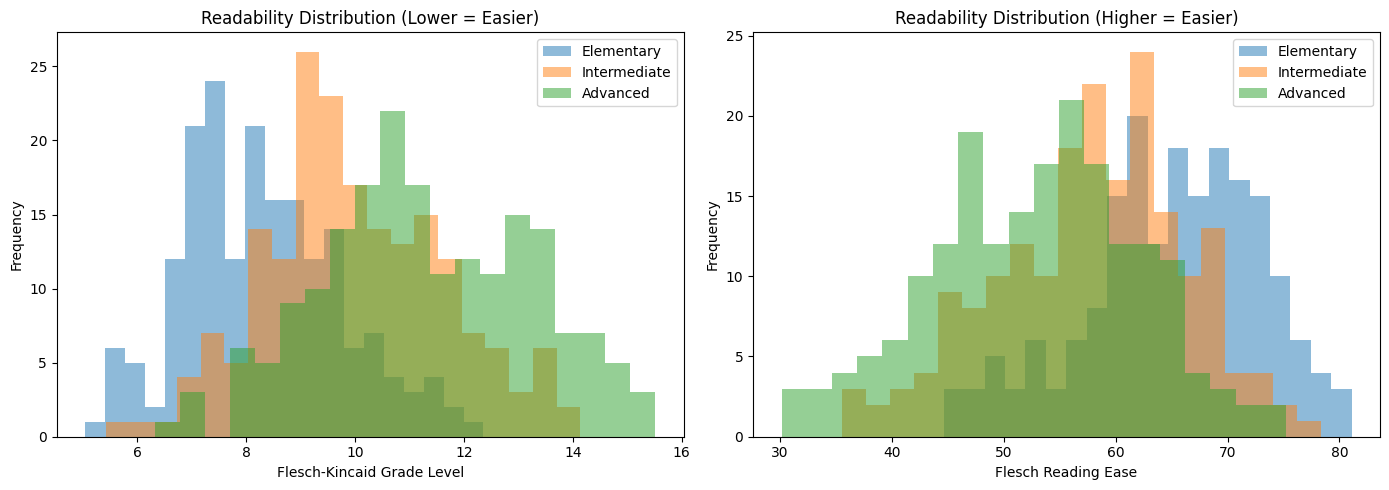

In [ ]:
# Checking that the three levels are significantly different reading levels

import textstat
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate readability scores for each level
wide['elem_fkgl'] = wide['elem'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
wide['inter_fkgl'] = wide['inter'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
wide['adv_fkgl'] = wide['adv'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))

wide['elem_fre'] = wide['elem'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
wide['inter_fre'] = wide['inter'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
wide['adv_fre'] = wide['adv'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

# Step 2: Summary statistics
print("=== FLESCH-KINCAID GRADE LEVEL (lower = easier) ===")
print(f"Elementary:   Mean={wide['elem_fkgl'].mean():.2f}, Median={wide['elem_fkgl'].median():.2f}")
print(f"Intermediate: Mean={wide['inter_fkgl'].mean():.2f}, Median={wide['inter_fkgl'].median():.2f}")
print(f"Advanced:     Mean={wide['adv_fkgl'].mean():.2f}, Median={wide['adv_fkgl'].median():.2f}")

print("\n=== FLESCH READING EASE (higher = easier) ===")
print(f"Elementary:   Mean={wide['elem_fre'].mean():.2f}, Median={wide['elem_fre'].median():.2f}")
print(f"Intermediate: Mean={wide['inter_fre'].mean():.2f}, Median={wide['inter_fre'].median():.2f}")
print(f"Advanced:     Mean={wide['adv_fre'].mean():.2f}, Median={wide['adv_fre'].median():.2f}")

# Step 3: Visualize the differences
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Flesch-Kincaid Grade Level
axes[0].hist(wide['elem_fkgl'], alpha=0.5, label='Elementary', bins=20)
axes[0].hist(wide['inter_fkgl'], alpha=0.5, label='Intermediate', bins=20)
axes[0].hist(wide['adv_fkgl'], alpha=0.5, label='Advanced', bins=20)
axes[0].set_xlabel('Flesch-Kincaid Grade Level')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Readability Distribution (Lower = Easier)')
axes[0].legend()

# Plot 2: Flesch Reading Ease
axes[1].hist(wide['elem_fre'], alpha=0.5, label='Elementary', bins=20)
axes[1].hist(wide['inter_fre'], alpha=0.5, label='Intermediate', bins=20)
axes[1].hist(wide['adv_fre'], alpha=0.5, label='Advanced', bins=20)
axes[1].set_xlabel('Flesch Reading Ease')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Readability Distribution (Higher = Easier)')
axes[1].legend()

plt.tight_layout()
plt.show()

Flesch–Kincaid Grade Level (FKGL): The FKGL scores increase from elementary (8.4) to intermediate (10.1) to advanced (~11.3), showing that texts at higher levels require progressively more years of education to comprehend.

SMOG Index: Similarly, SMOG scores rise from ~10.1 (elementary) to ~12.2 (intermediate) to ~13.0 (advanced), confirming that advanced texts demand greater reading proficiency due to longer sentences and more polysyllabic words.

This confirms that the dataset’s readability levels are aligned with the intended difficulty progression.

In [ ]:
REPO = "iastate/onestop_english"

# list files in the HF dataset repo
files = list_repo_files(REPO, repo_type="dataset")
print("Files:", files[:10])

# pick first parquet/csv file
cands = [f for f in files if f.lower().endswith((".parquet", ".csv"))]
fname = cands[0]
print("Using:", fname)

# download file
local_path = hf_hub_download(repo_id=REPO, filename=fname, repo_type="dataset")

# load into pandas
df = pd.read_parquet(local_path) if fname.endswith(".parquet") else pd.read_csv(local_path)

# map numeric labels → text levels
label2level = {0: "elementary", 1: "intermediate", 2: "advanced"}
df["level"] = df["label"].map(label2level)

print(df.head())


Files: ['.gitattributes', 'README.md', 'data/train-00000-of-00001.parquet']
Using: data/train-00000-of-00001.parquet
                                                text  label       level
0  When you see the word Amazon, what’s the first...      0  elementary
1  To tourists, Amsterdam still seems very libera...      0  elementary
2  Anitta, a music star from Brazil, has millions...      0  elementary
3  Google has made maps of the world’s highest mo...      0  elementary
4  The auction of a Banksy painting that disappea...      0  elementary


              count        mean         std    min    25%    50%    75%  \
level                                                                     
advanced      189.0  824.783069  162.939032  345.0  716.0  820.0  945.0   
elementary    189.0  534.645503  103.283931  259.0  463.0  545.0  614.0   
intermediate  189.0  677.899471  117.128932  315.0  604.0  691.0  764.0   

                 max  
level                 
advanced      1368.0  
elementary     884.0  
intermediate  1081.0  


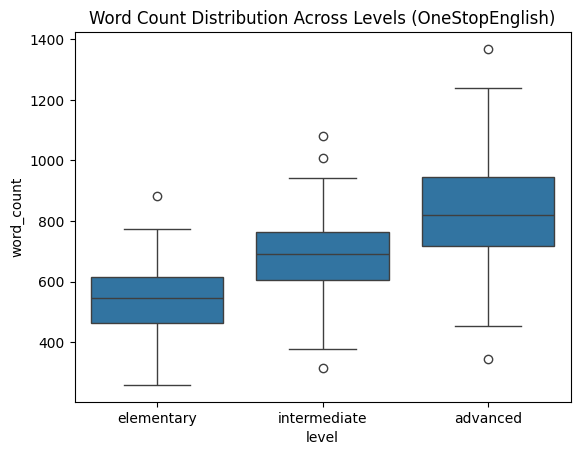

In [ ]:
# word count per sample
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))

# summary stats by level
print(df.groupby("level")["word_count"].describe())

# boxplot comparison
order = ["elementary", "intermediate", "advanced"]
sns.boxplot(data=df, x="level", y="word_count", order=order)
plt.title("Word Count Distribution Across Levels (OneStopEnglish)")
plt.show()


Average word counts increase with text level, from ~534 words at elementary to ~678 at intermediate and ~825 at advanced. This confirms that text complexity in the dataset scales as expected, with advanced articles consistently longer and more detailed than lower-level ones.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


=== Unique Words by Level ===
              count        mean        std    min    25%    50%    75%    max
level                                                                        
advanced      189.0  433.862434  76.858686  202.0  381.0  434.0  489.0  667.0
elementary    189.0  279.216931  47.942569  147.0  245.0  279.0  316.0  416.0
intermediate  189.0  351.275132  53.735844  185.0  318.0  349.0  391.0  528.0

=== Avg Sentence Length by Level ===
              count       mean       std        min        25%        50%  \
level                                                                       
advanced      189.0  28.838361  5.051631  17.657534  25.156250  28.666667   
elementary    189.0  21.638915  3.242707  13.875000  19.656250  21.583333   
intermediate  189.0  22.170063  3.019545  14.806452  20.210526  22.111111   

                    75%        max  
level                               
advanced      32.250000  53.411765  
elementary    23.068966  39.700000  
intermed

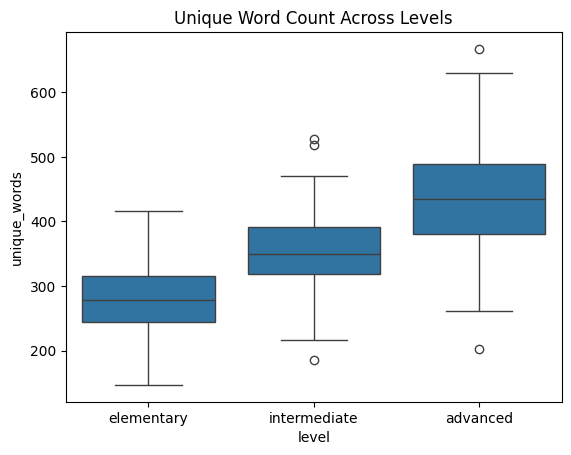

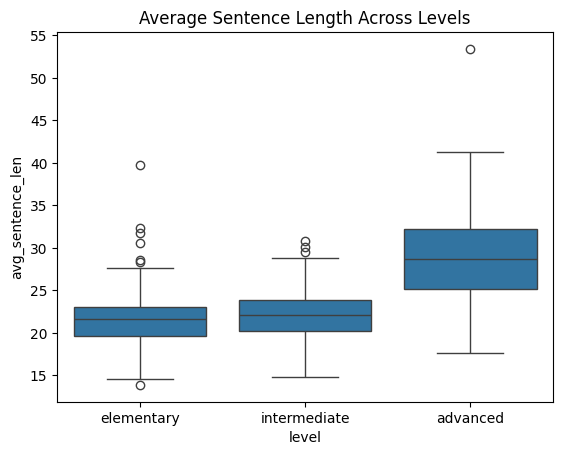

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

from nltk.tokenize import sent_tokenize, word_tokenize

# unique word count
df["unique_words"] = df["text"].apply(lambda x: len(set(str(x).lower().split())))

# helper: avg sentence length
def avg_sentence_length(text):
    text = str(text)
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    return len(words) / len(sentences) if len(sentences) > 0 else 0

# compute for each sample
df["avg_sentence_len"] = df["text"].apply(avg_sentence_length)

# display stats
print("=== Unique Words by Level ===")
print(df.groupby("level")["unique_words"].describe())

print("\n=== Avg Sentence Length by Level ===")
print(df.groupby("level")["avg_sentence_len"].describe())

# plots
order = ["elementary", "intermediate", "advanced"]

sns.boxplot(data=df, x="level", y="unique_words", order=order)
plt.title("Unique Word Count Across Levels")
plt.show()

sns.boxplot(data=df, x="level", y="avg_sentence_len", order=order)
plt.title("Average Sentence Length Across Levels")
plt.show()


In [ ]:
# Topic Preservation Across Levels
# Check if articles across levels talk about the same topics. For example, use TF-IDF + cosine similarity.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# pick one story aligned across levels
sample_id = 10
texts = df.iloc[sample_id:sample_id+3]["text"].tolist()
levels = df.iloc[sample_id:sample_id+3]["level"].tolist()

vectorizer = TfidfVectorizer(stop_words="english")
tfidf = vectorizer.fit_transform(texts)

sim_matrix = cosine_similarity(tfidf)
print("Cosine similarity between levels:", sim_matrix)



Cosine similarity between levels: [[1.         0.02162675 0.05017588]
 [0.02162675 1.         0.02338966]
 [0.05017588 0.02338966 1.        ]]


In [ ]:
# Word Frequency Differences
# Compare which words are most frequent at each level.

from collections import Counter
import re

def get_top_words(level, n=10):
    texts = " ".join(df[df["level"]==level]["text"].tolist()).lower()
    words = re.findall(r"\b[a-z]+\b", texts)
    return Counter(words).most_common(n)

print("Elementary top words:", get_top_words("elementary"))
print("Intermediate top words:", get_top_words("intermediate"))
print("Advanced top words:", get_top_words("advanced"))


Elementary top words: [('the', 6118), ('and', 2579), ('to', 2568), ('of', 2466), ('a', 2328), ('in', 2283), ('that', 1483), ('is', 1337), ('it', 1098), ('for', 915)]
Intermediate top words: [('the', 7786), ('of', 3581), ('to', 3489), ('and', 3324), ('a', 3132), ('in', 2824), ('that', 1707), ('is', 1646), ('for', 1205), ('it', 1111)]
Advanced top words: [('the', 9573), ('of', 4560), ('to', 4442), ('and', 3988), ('a', 3915), ('in', 3441), ('that', 1936), ('is', 1840), ('it', 1562), ('for', 1474)]


In [ ]:
# Alignment Check:

n = 189  # number of samples per level
df["article_id"] = df.index % n


for i in range(3):  # check first 3 aligned groups
    print(f"\n=== ARTICLE {i} ===")
    print(df[df["article_id"] == i][["level","text"]])



=== ARTICLE 0 ===
            level                                               text
0      elementary  When you see the word Amazon, what’s the first...
189  intermediate  Intermediate\nWhen you see the word Amazon, wh...
378      advanced  When you see the word Amazon, what’s the first...

=== ARTICLE 1 ===
            level                                               text
1      elementary  To tourists, Amsterdam still seems very libera...
190  intermediate  Intermediate\nTo tourists, Amsterdam still see...
379      advanced  Amsterdam still looks liberal to tourists, who...

=== ARTICLE 2 ===
            level                                               text
2      elementary  Anitta, a music star from Brazil, has millions...
191  intermediate  Intermediate\nBrazils latest funk sensation, A...
380      advanced  Brazil’s latest funk sensation, Anitta, has wo...


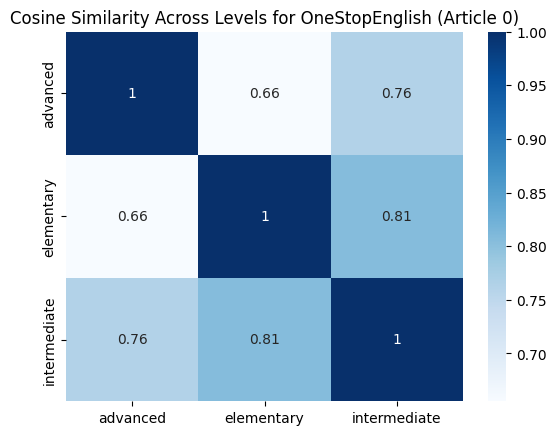

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Pick an aligned article (e.g., id=0)
article_id = 0
subset = df[df["article_id"] == article_id].sort_values("level")

texts = subset["text"].tolist()
levels = subset["level"].tolist()

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english")
tfidf = vectorizer.fit_transform(texts)

# Cosine similarity matrix
sim_matrix = cosine_similarity(tfidf)

# Heatmap
sns.heatmap(sim_matrix, annot=True, xticklabels=levels, yticklabels=levels, cmap="Blues")
plt.title(f"Cosine Similarity Across Levels for OneStopEnglish (Article {article_id})")
plt.show()


In [ ]:
sims = []

for i in df["article_id"].unique():
    subset = df[df["article_id"] == i].sort_values("level")
    texts = subset["text"].tolist()
    tfidf = vectorizer.fit_transform(texts)
    sim_matrix = cosine_similarity(tfidf)
    sims.append(sim_matrix[np.triu_indices(3, k=1)])  # upper triangle (pairwise sims)

avg_sim = np.mean(np.vstack(sims), axis=0)
print("Average cosine similarities (adv–int, adv–elem, int–elem):", avg_sim)


Average cosine similarities (adv–int, adv–elem, int–elem): [0.69792643 0.80503604 0.75333517]
